#  Essa porta não tem espaço suficiente para nós dois

### Uma análise exploratória e modelagem das sobrevivências do Titanic 


![alt text](https://m0.her.ie/wp-content/uploads/2016/01/14165912/leospace.jpg "Logo Title Text 1")


# Sumário

**1.** Data Dictionary

**2.** Importando as ferramentas necessárias e o dataset

**3.** Explorando o dataset

**4.** Missings

**5.** Feature Engineering

**6.** Modelagem

**7.** Submissão

**8.** Referências




## 1. Data Dictionary

**Keys**

0 = No, 1 = Yes

1 = 1st, 2 = 2nd, 3 = 3rd

**Variable	Definition**	
   - **survival**:	Survival	
   - **pclass**:	    Ticket class	
   - **sex	**:       Sex	
   - **Age**	:        Age in years	
   - **sibsp**	 :   # of siblings / spouses aboard the Titanic	
   - **parch	**:    # of parents / children aboard the Titanic	
   - **ticket**	   : Ticket number	
   - **fare**	  :  Passenger fare	
   - **cabin	** :   Cabin number	
   - **embarked	**:Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
   - **Variable** :   Notes

**pclass**: A proxy for socio-economic status

1st = Upper

2nd = Middle

3rd = Lower

**Age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**Sibsp**: The dataset defines family relations in this way...

   - Sibling = brother, sister, stepbrother, stepsister

   - Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...

   - Parent = mother, father

   - Child = daughter, son, stepdaughter, stepson

      - Some children travelled only with a nanny, therefore parch=0 for them.

# 2. Importando as ferramentas necessárias e o dataset

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import gc
import math

#libs de visualizacao
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
from IPython.core.display import HTML
from mlxtend.plotting import plot_decision_regions

#Figuras aparecerem nos outputs das células
%matplotlib inline

#ignora warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Formato de gráfico padrão 

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
pd.options.display.float_format = '{:.2f}'.format
rc={'savefig.dpi': 75, 'figure.autolayout': False, 'figure.figsize': [12, 8], 'axes.labelsize': 18,\
   'axes.titlesize': 18, 'font.size': 18, 'lines.linewidth': 2.0, 'lines.markersize': 8, 'legend.fontsize': 16,\
   'xtick.labelsize': 16, 'ytick.labelsize': 16}

sns.set(style='darkgrid',rc=rc)

default_color = '#56B4E9'
colormap = plt.cm.cool

In [3]:
#importa os Datasets de treino e validação
test = pd.read_csv('../test.csv')
train = pd.read_csv('../train.csv')

In [4]:
#Cria a lista de id's teste para submeter ao kaggle depois
id_test = test['PassengerId'].values

In [5]:
#retira os Id's dos datasets
train = train.drop([ 'PassengerId'], axis = 1)
test = test.drop([ 'PassengerId'], axis = 1)

## 3. Explorando o Dataset

In [6]:
print('O dataset de treino contém:')
print(train.shape[0], 'linhas')
print(train.shape[1], 'colunas')
print()
print('O dataset de teste contém:')
print(test.shape[0], 'linhas')
print(test.shape[1], 'colunas')

O dataset de treino contém:
891 linhas
11 colunas

O dataset de teste contém:
418 linhas
10 colunas


In [7]:
print('Colunas do dataset:')
print (train.columns)

Colunas do dataset:
Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [8]:
#mostra as 5 primeiras linhas do dataset de treino
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [9]:
# Concatena os datasets de treino e teste na variavel data
data = pd.concat([train.drop('Survived', axis = 1), test], ignore_index = True)
data.shape

(1309, 10)

In [10]:
# Mostra estatísticas do dataset 'data'
data.describe()

,Pclass,Age,SibSp,Parch,Fare
count,1309.00,1046.00,1309.00,1309.00,1308.00
mean,2.29,29.88,0.50,0.39,33.30
std,0.84,14.41,1.04,0.87,51.76
min,1.00,0.17,0.00,0.00,0.00
25%,2.00,21.00,0.00,0.00,7.90
50%,3.00,28.00,0.00,0.00,14.45
75%,3.00,39.00,1.00,0.00,31.27
max,3.00,80.00,8.00,9.00,512.33


Com o método .describe(), pode-se notar que:
- Na linha **count**, podemos perceber que do total de linhas (1309), as variáveis **Age**  e **Fare** tem valores faltando, o que será investigado mais a frente

In [11]:
def get_meta(train):
    ''' Cria um dataframe que mostra os tipos de cada variável do dataset '''
    
    data = []
    for col in train.columns:
        # Defining the role
        if col == 'target':
            role = 'target'
        elif col == 'id':
            role = 'id'
        else:
            role = 'input'

        # Defining the level
        if 'bin' in col or col == 'target':
            level = 'binary'
        elif 'cat' in col or col == 'id':
            level = 'nominal'
        elif train[col].dtype == np.float64:
            level = 'interval'
        elif train[col].dtype == np.int64:
            level = 'ordinal'

        # Initialize keep to True for all variables except for id
        keep = True
        if col == 'id':
            keep = False

        # Defining the data type 
        dtype = train[col].dtype

        # Creating a Dict that contains all the metadata for the variable
        col_dict = {
            'varname': col,
            'role'   : role,
            'level'  : level,
            'keep'   : keep,
            'dtype'  : dtype
        }
        data.append(col_dict)
    meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
    meta.set_index('varname', inplace=True)
    return meta

In [12]:
meta_data = get_meta(train)
meta_data

,role,level,keep,dtype
varname,,,,
Survived,input,ordinal,True,int64
Pclass,input,ordinal,True,int64
Name,input,ordinal,True,object
Sex,input,ordinal,True,object
Age,input,interval,True,float64
SibSp,input,ordinal,True,int64
Parch,input,ordinal,True,int64
Ticket,input,ordinal,True,object
Fare,input,interval,True,float64


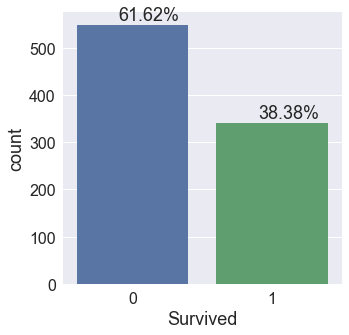

In [13]:
# plota o gráfico de quantas pessoas sobreviveram (1) e quantas morreram (0)
plt.figure(figsize=(5,5))

ax = sns.countplot('Survived',data=train, )
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(train['Survived'])), (p.get_x()+ 0.3, p.get_height()+10))


A partir desse gráfico, pode-se notar que o dataset (de treino) possui mais dados de pessoas que morreram do que de sobreviventes. Esse desbalanceamento acarretará alguns preprocessamentos necessários na fase de modelagem, assim como a escolha da métrica de desempenho dos modelos testados.


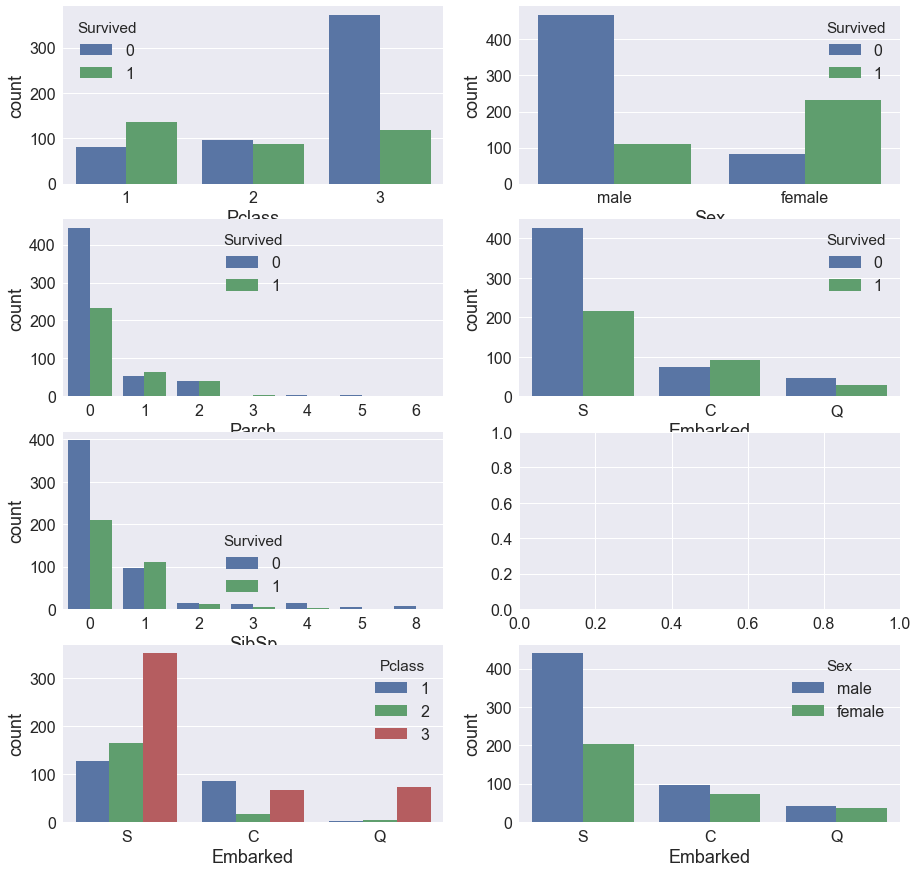

In [14]:
# Plota gráficos para analisar a relação de sobreviventes com as outras variáveis.

fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize=(15,15))
sns.countplot(x="Pclass", data=train, hue = 'Survived', ax=ax[0,0])
sns.countplot(x="Sex", data=train, hue = 'Survived', ax=ax[0,1])
sns.countplot(x="Parch", data=train, hue = 'Survived', ax=ax[1,0])
sns.countplot(x="SibSp", data=train, hue = 'Survived', ax=ax[2,0])
sns.countplot(x="Embarked", data=train, hue = 'Survived', ax=ax[1,1])
sns.countplot(x="Embarked", data=train, hue = 'Pclass', ax=ax[3,0])
sns.countplot(x="Embarked", data=train, hue = 'Sex', ax=ax[3,1])

fig.show()

Esses gráficos mostram que:
- **PClass**: quanto mais baixa a classe de um passageiro, menores as chances dele sobreviver, isso poderia ser explicado pela provável preferência no salvamento de pessoas mais ricas (1a classe).
- **Sex**: "Mulheres e crianças primeiro!". Mulheres tem maior taxa de sobrevivencia do que homens, pois eram as que entravam primeiro nos botes.
- **Parch** e **SibSp**:Aparentemente, quem não tinha parentes no barco tinha maior probabilidade de não sobreviver.
- **Embarked**: Tecnicamente, o lugar de embarque das pessoas não deveria ser um fator decisivo na sua sobrevivência, e provavelmente não é, pois, como pode ser visto nos gráficos da linha 4, muitas pessoas que embarcaram em Southampton eram da 2a e 3a classe e homens, fatores decisivos para sua sobrevivência que estão escondidos por tras dessa variável.

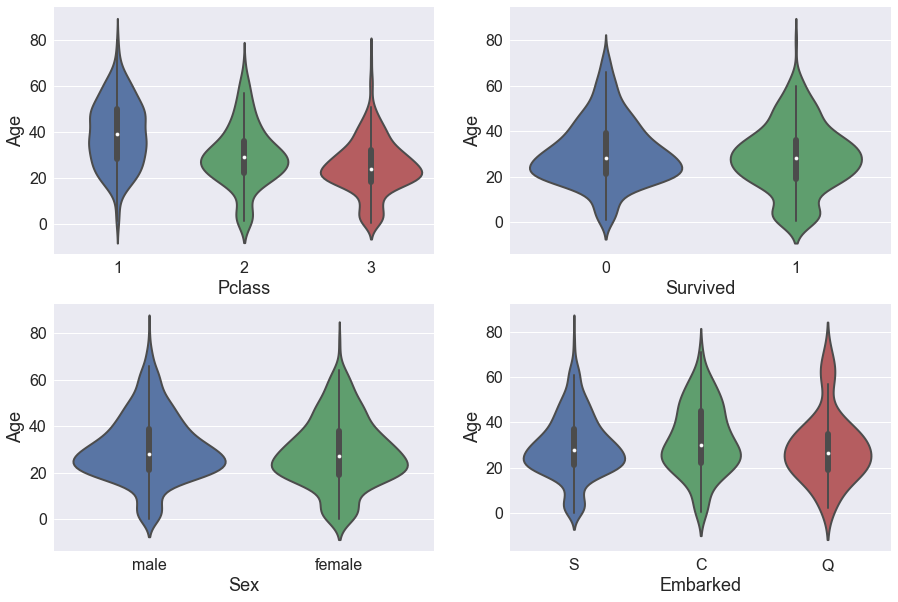

In [15]:
#Investiga as idades dos passageiros
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(15,10))

sns.violinplot( x=data["Pclass"], y=data["Age"], ax=ax[0,0])
sns.violinplot( x=data["Sex"], y=data["Age"], ax=ax[1,0] )
sns.violinplot( x=train["Survived"], y=train["Age"], ax=ax[0,1])
sns.violinplot( x=data["Embarked"], y=data["Age"], ax=ax[1,1] )
plt.show()


Esses gráficos mostram que:
- Crianças tem mais chances de sobreviver, o que ja era esperado, pois junto com as mulheres, são as primeiras a irem para os botes salva-vidas
- Quanto melhor a classe, mais velhas (em média) são as pessoas


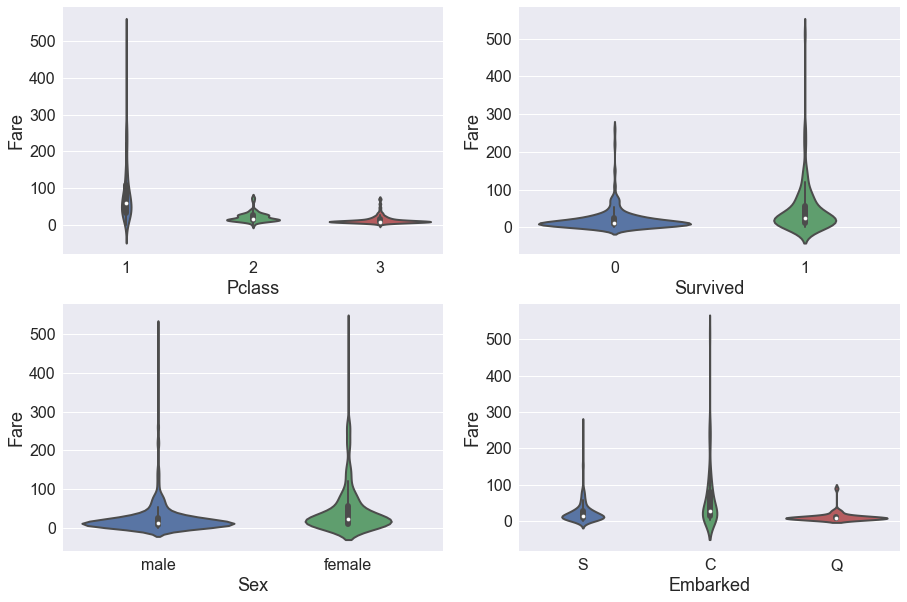

In [16]:
#investiga a relação entre as variáveis e quanto as pessoas pagaram

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(15,10))

sns.violinplot( x=data["Pclass"], y=data["Fare"], ax=ax[0,0])
sns.violinplot( x=data["Sex"], y=data["Fare"], ax=ax[1,0] )
sns.violinplot( x=train["Survived"], y=train["Fare"], ax=ax[0,1])
sns.violinplot( x=data["Embarked"], y=data["Fare"], ax=ax[1,1] )

plt.show()

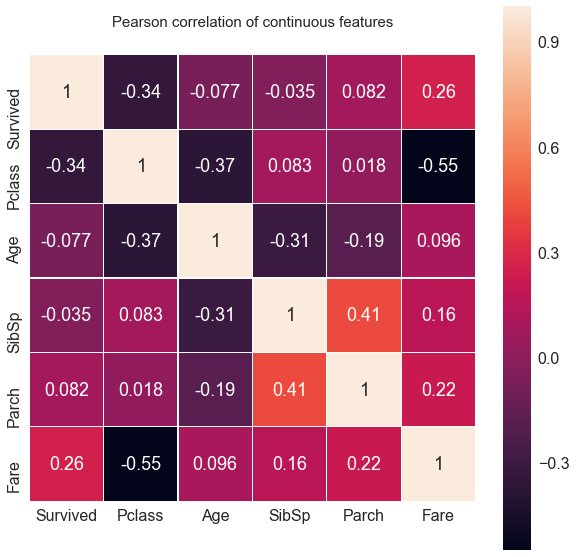

In [17]:
# Plota a correlação entre as variáveis
plt.figure(figsize=(10, 10))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train.corr(),linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=True)
plt.show()

O gráfico de correlação mostra que:
- A classe é invesamente proporcional ao quanto a pessoa pagou
- A classe é invesamente proporcional à idade
- A sobrevivência parece não estar muito correlacionada com **Parch**, **SibSp** e **Age**. Este útimo pode ser enganoso a primeira vista, pois a relação de sobrevivência está ligada mais à crianças do que a adultos e estes, como eram maioria, fazem com que a correlação pareça mais fraca do que é.

# 4. Missings

Nessa sessão foram investigados os valores faltantes no dataset, que aparecem como NaN. Algumas técnicas de preenchimentos desses valores foram utilizadas.

In [18]:
#cria um dataframe com variaveis que tem nulos
missingValueColumns = data.columns[data.isnull().any()].tolist()
df_null_data = data[missingValueColumns] 
df_null_data.tail()

,Age,Fare,Cabin,Embarked
1304,nan,8.05,NaN,S
1305,39.00,108.90,C105,C
1306,38.50,7.25,NaN,S
1307,nan,8.05,NaN,S
1308,nan,22.36,NaN,C


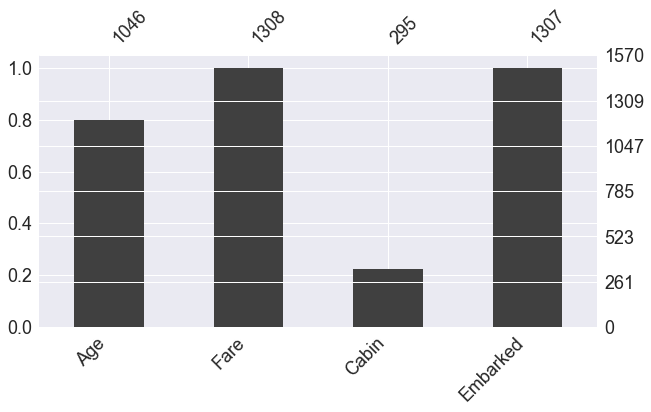

In [19]:
msno.bar(df_null_data,figsize=(10,5),fontsize=18,labels=True)

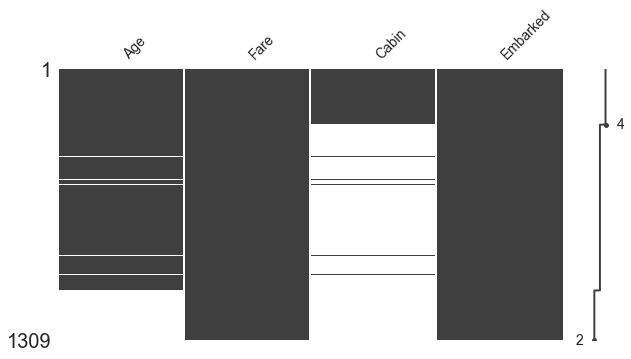

In [20]:
#Esse gráfico mostra o dataset: Em preto, os valores presentes. Em branco, os faltantes.
sorted_data = msno.nullity_sort(df_null_data, sort='descending') # or sort='ascending'
msno.matrix(sorted_data,figsize=(10,5),fontsize=14)

Com estes gráficos, pode-se perceber que **Age**, **Embarked** e **Fare** possuem muitos valores faltantes. Fare e Embarked não são tãp críticos, pois como já foi observado, esses valores estão correlacionados com outros e não são muito impactantes na sobrevivência ao desastre. Por outro lado, **Age** é um valor crucial e seu preenchimento impactará diretamente no resultado final da modelagem.

In [21]:
#Conta quantos nulos existem em data
df_null_data.isnull().sum()

Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64

In [22]:
#vamos colocar valores para o Embarked... Como a moda é S, foi colocado o valor S. 
# Espera-se que não seja essa variável que fará a diferença na classificação, pois as mortes em cada classe 
# são praticamente distribuidas igualmente

train.Embarked.fillna('S', inplace=True)
test.Embarked.fillna('S', inplace=True)

In [23]:
# Preenche os valores de cabine faltando com 'n', ou seja, a pessoa não tem cabine
train.Cabin.fillna('n', inplace=True)
test.Cabin.fillna('n', inplace=True)

In [24]:
test[test.Fare.isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,3,"Storey, Mr. Thomas",male,60.50,0,0,3701,nan,n,S


In [25]:
#Cálculo da média de 'Fare' para cada classe.

#cria um novo df f_c
f_c = pd.concat([data['Fare'], data['Pclass']], axis = 1)
f_c.head()

,Fare,Pclass
0,7.25,3
1,71.28,1
2,7.92,3
3,53.10,1
4,8.05,3


In [26]:
# Acha a média de Fare agrupado por Pclass
f_c_mean = f_c.groupby('Pclass', as_index=False)['Fare'].mean()
f_c_mean

#se quiser agrupar por mais de uma coluna
# df.groupby(['Column1', 'Cloumn2']).agg({'dtype': lambda x: x.mean()}).reset_index()

,Pclass,Fare
0,1,87.51
1,2,21.18
2,3,13.30


In [27]:
#Completa a Fare que estava faltando com a fare média da sua classe (3)
test.Fare.fillna(f_c_mean.Fare[2], inplace=True)

In [28]:
# Quantas variáveis ainda tem NaN? e quantos?
train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin         0
Embarked      0
dtype: int64

**Age** será preenchido na próxima sessão.

# 5. Feature Engineering

In [29]:
#Cria novos dataframes, para deixar os originais intactos

trainf = train.copy()
testf = test.copy()

In [30]:
trainf.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,n,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,n,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,n,S


## 5.1 Sexo

In [31]:
trainf['Sex'] = np.where(trainf['Sex'] == "male" , 0 , 1)
testf['Sex'] = np.where(testf['Sex'] == "male" , 0 , 1)

## 5.2 Nomes

In [32]:
def get_titles():
    '''Essa função extrai os Titles dos nomes e nomeia-os adequadamente'''
    global combined
    
    # extrai os Titles de cada noma
    trainf['Title'] = trainf['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    testf['Title'] = testf['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    data['Title'] = data['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # um mapa dos Titles
    Title_Dictionary = {
                        "Capt":       "Officer",
                        "Col":        "Officer",
                        "Major":      "Officer",
                        "Jonkheer":   "Royalty",
                        "Don":        "Royalty",
                        "Sir" :       "Royalty",
                        "Dr":         "Officer",
                        "Rev":        "Officer",
                        "the Countess":"Royalty",
                        "Dona":       "Royalty",
                        "Mme":        "Mrs",
                        "Mlle":       "Miss",
                        "Ms":         "Mrs",
                        "Mr" :        "Mr",
                        "Mrs" :       "Mrs",
                        "Miss" :      "Miss",
                        "Master" :    "Master",
                        "Lady" :      "Royalty"

                        }
    # mapeia-se cada Title
    trainf['Title'] = trainf.Title.map(Title_Dictionary)
    testf['Title'] = testf.Title.map(Title_Dictionary)
    data['Title'] = data.Title.map(Title_Dictionary)

In [33]:
get_titles()

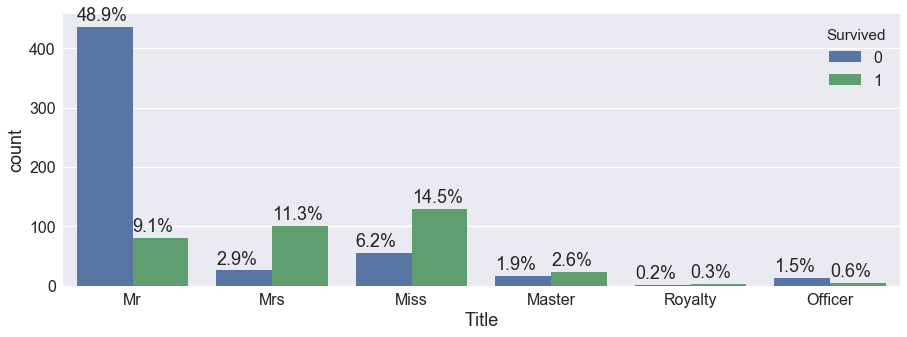

In [34]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x="Title", data=trainf, hue = 'Survived')
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(trainf['Survived'])), (p.get_x()+ 0, p.get_height()+10))
plt.show()

Uma nova coluna foi adicionada, com o nome de **Title**, contendo os títulos dos nomes. O gráfico acima mostra a taxa de sobrevivência de cada Título

## 5.3 Família

In [35]:
# Cria uma nova coluna 'is_alone' que mostra se a pessoa estava sozinha no barco
# 1 = Sozinha, 0 = Acompanhada

trainf['is_alone'] = np.where((trainf['SibSp'] == 0) & (trainf['Parch'] == 0) , 1, 0)
testf['is_alone'] = np.where((testf['SibSp'] == 0) & (testf['Parch'] == 0) , 1, 0)

In [36]:
# Cria uma variável com o total de pessoas na familia
trainf['family_size'] = trainf['SibSp'] + trainf['Parch']
testf['family_size'] = testf['SibSp'] + testf['Parch']

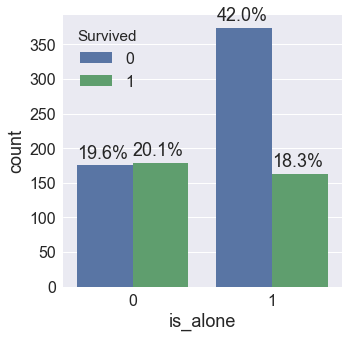

In [37]:
# plota o gráfico de sobreviventes em relação a variável is_alone
plt.figure(figsize=(5,5))
ax = sns.countplot(x="is_alone", data=trainf, hue = 'Survived')
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(trainf['Survived'])), (p.get_x()+ 0, p.get_height()+10))
plt.show()

Aqui, algo interessante... pessoas sozinhas tinham menos chances de sobreviver.

## 5.4 Cabine

In [38]:
#cria uma coluna que contém apenas a letra da cabine
trainf['Cabine_letra'] = trainf['Cabin'].str[0]
testf['Cabine_letra'] = testf['Cabin'].str[0]


In [39]:
# Quais letras existem?
trainf.Cabine_letra.unique()

array(['n', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

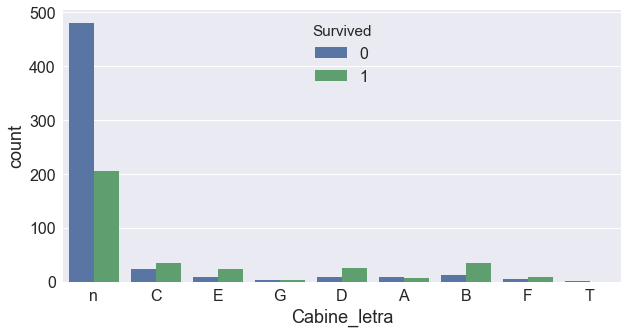

In [40]:
#plota o gráfico de sobreviventes por letra da cabine
plt.figure(figsize=(10,5))
ax = sns.countplot(x="Cabine_letra", data=trainf , hue = 'Survived')
plt.show()

Não se sabe o porque da falta de muitos dados de cabine, se é devido ao fato das pessoas não terem cabine ou pelo fato de ser apenas um item faltante no dataset. Muito provavelmente a razão é a última, mas o gráfico acima mostra um comportamento interessante: pessoas com cabine escrita sobreviveram mais... será que muitos, depois de sobreviverem, tiveram suas cabines documentadas? talvez.

In [41]:
#cria uma coluna que contém apenas o número da cabine
trainf['Cabine_num'] = trainf['Cabin'].str[1:4]
testf['Cabine_num'] = testf['Cabin'].str[1:4]
trainf['Cabine_num'] = trainf['Cabine_num'].str.strip()
testf['Cabine_num'] = testf['Cabine_num'].str.strip()

In [42]:
# Coloca alguns números na mão, são posições que deram problema
trainf['Cabine_num'][75] = 7
trainf['Cabine_num'][128] = 6
trainf['Cabine_num'][699] = 6
trainf['Cabine_num'][715] = 7

In [43]:
#Transoforma a coluna Cabine_num em numérica
trainf['Cabine_num'] = pd.to_numeric(trainf['Cabine_num'])

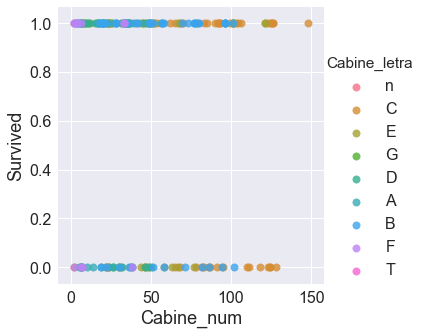

In [44]:
#plota o gráfico de sobreviventes por numero da cabine
sns.lmplot(x="Cabine_num", y="Survived", hue = 'Cabine_letra', fit_reg = False,
               truncate=True, size=5, data=trainf)

Com o gráfico acima, percebe-se que a sobrevivência não está relacionada com o número da cabine

In [45]:
# Atribui valores binários para a coluna Cabin
# 0 = não tem cabine
# 1 = tem cabine

trainf['Cabin'] = np.where(trainf['Cabin'] == "n" , 0, 1)
testf['Cabin'] = np.where(testf['Cabin'] == "n" , 0, 1)

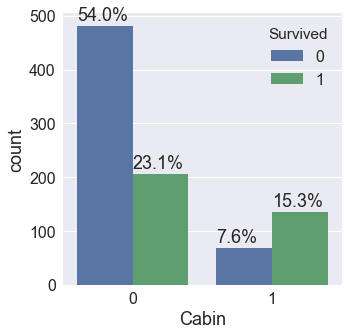

In [46]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x="Cabin", data=trainf, hue = 'Survived')
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(trainf['Survived'])), (p.get_x()+ 0, p.get_height()+10))
plt.show()

Esse gráfico evidencia o que ja foi dito acima, pessoas com cabine documentada tem uma maior taxa de sobrevivência.

## 5.5 Fare

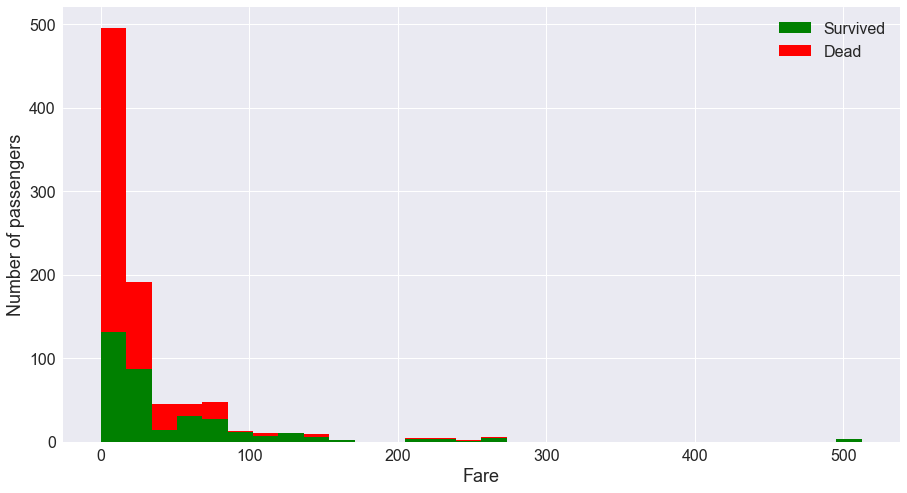

In [47]:
# Vamos analisar melhor essa variável, com um histograma
figure = plt.figure(figsize=(15,8))
plt.hist([train[train['Survived']==1]['Fare'],train[train['Survived']==0]['Fare']], stacked=True, color = ['g','r'],
         bins = 30,label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

Muitas pessoas não pagaram nada pela passagem e aparentemente sobreviveram menos.

In [48]:
#Separa a variável fare em pessoas que não pagaram nada (Fare_0), os que pagaram um preço médio ('Fare_medium') e os que
# pagaram muito (Fare_high)
trainf['Fare_0'] = np.where(trainf['Fare'] == 0, 1,0)
trainf['Fare_medium'] = np.where(( trainf['Fare'] > 0  ) & ( trainf['Fare'] < 80  ), 1,0) 
trainf['Fare_high'] = np.where(trainf['Fare'] >= 80 , 1,0 )       

testf['Fare_0'] = np.where(testf['Fare'] == 0, 1,0)
testf['Fare_medium'] = np.where(( testf['Fare'] > 0  ) & ( testf['Fare'] < 80  ), 1,0) 
testf['Fare_high'] = np.where(testf['Fare'] >= 80 , 1,0 ) 


In [49]:
trainf['Fare_0'].count()

891

## 5.6 Age

Chegou a hora de encarar essa variável. Vamos ver se os títulos dos nomes dão algum insight sobre como prever essa variável.

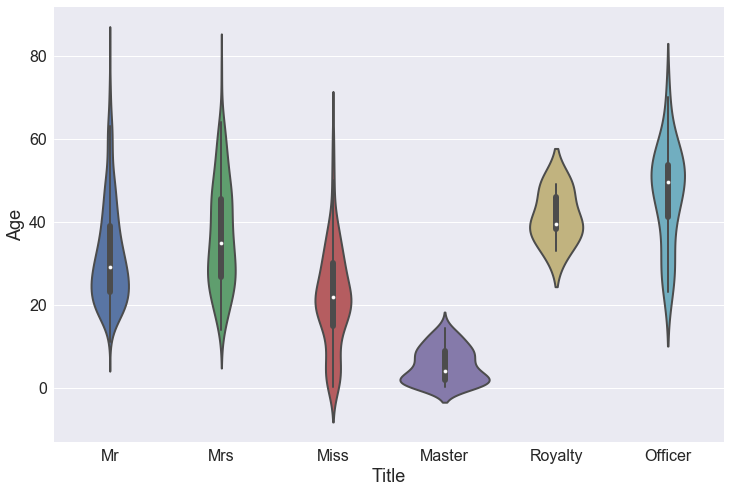

In [50]:
sns.violinplot( x=data["Title"], y=data["Age"])

In [51]:
#agrupa por Título
age_mean = data.groupby(['Title']).mean()
age_mean['Age']

Title
Master     5.48
Miss      21.80
Mr        32.25
Mrs       36.87
Officer   46.27
Royalty   41.17
Name: Age, dtype: float64

Uma pista: o Título Master é designado a pessoas novas, com média de idade de 5 anos

In [52]:
#Substitui os valores de idade nulos pela média das idades dos Títulos

trainf.loc[(trainf['Age'].isnull()) & (trainf['Title']=='Master'), 'Age'] = 5.48
trainf.loc[(trainf['Age'].isnull()) & (trainf['Title']=='Miss'), 'Age'] = 21.80
trainf.loc[(trainf['Age'].isnull()) & (trainf['Title']=='Mr'), 'Age'] = 32.25
trainf.loc[(trainf['Age'].isnull()) & (trainf['Title']=='Mrs'), 'Age'] = 36.87
trainf.loc[(trainf['Age'].isnull()) & (trainf['Title']=='Officer'), 'Age'] = 46.27
trainf.loc[(trainf['Age'].isnull()) & (trainf['Title']=='Royalty'), 'Age'] = 41.17

testf.loc[(testf['Age'].isnull()) & (testf['Title']=='Master'), 'Age'] = 5.48
testf.loc[(testf['Age'].isnull()) & (testf['Title']=='Miss'), 'Age'] = 21.80
testf.loc[(testf['Age'].isnull()) & (testf['Title']=='Mr'), 'Age'] = 32.25
testf.loc[(testf['Age'].isnull()) & (testf['Title']=='Mrs'), 'Age'] = 36.87
testf.loc[(testf['Age'].isnull()) & (testf['Title']=='Officer'), 'Age'] = 46.27
testf.loc[(testf['Age'].isnull()) & (testf['Title']=='Royalty'), 'Age'] = 41.17

In [53]:
#Separa a Faixa Etária
kid = 10
adult = 50


trainf['Age_class'] = 0
trainf.loc[(trainf['Age'] <= kid), 'Age_class'] = 0
trainf.loc[(trainf['Age'] > kid) & (trainf['Age'] < adult), 'Age_class'] = 1
trainf.loc[(trainf['Age'] >= adult), 'Age_class'] = 2

testf['Age_class'] = 0
testf.loc[(trainf['Age'] <= kid), 'Age_class'] = 0
testf.loc[(trainf['Age'] > kid) & (testf['Age'] < adult), 'Age_class'] = 1
testf.loc[(trainf['Age'] >= adult), 'Age_class'] = 2



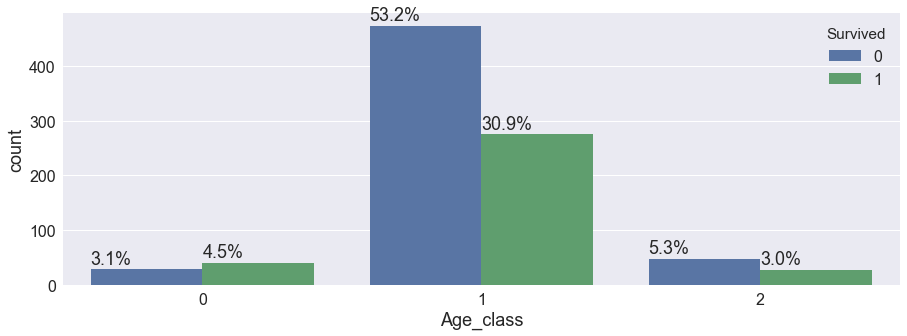

In [54]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x="Age_class", data=trainf, hue = 'Survived')
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/len(trainf['Survived'])), (p.get_x()+ 0, p.get_height()+10))
plt.show()

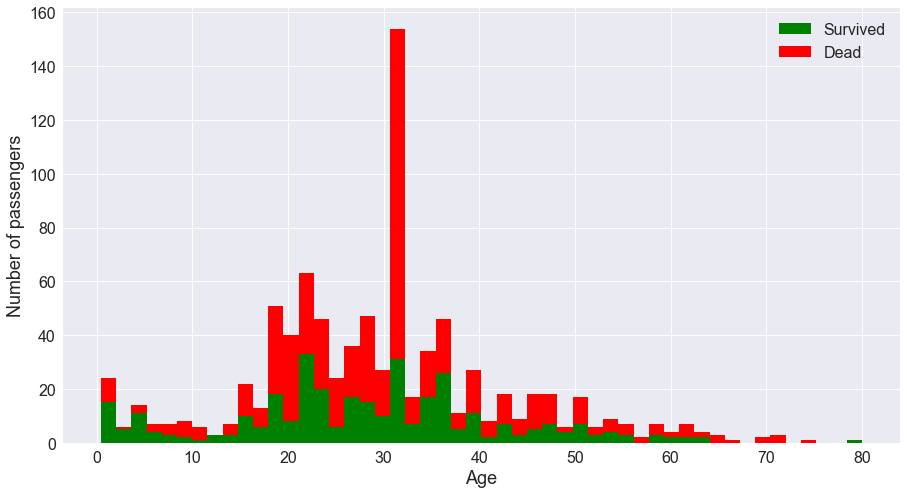

In [55]:
figure = plt.figure(figsize=(15,8))
plt.hist([trainf[trainf['Survived']==1]['Age'],trainf[trainf['Survived']==0]['Age']], stacked=True, color = ['g','r'], bins = 50,
         label = ['Survived','Dead'])
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend()

Com tantas adições, a tabela fica assim:

In [56]:
trainf.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,is_alone,family_size,Cabine_letra,Cabine_num,Fare_0,Fare_medium,Fare_high,Age_class
0,0,3,"Braund, Mr. Owen Harris",0,22.00,1,0,A/5 21171,7.25,0,S,Mr,0,1,n,nan,0,1,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.00,1,0,PC 17599,71.28,1,C,Mrs,0,1,C,85.00,0,1,0,1
2,1,3,"Heikkinen, Miss. Laina",1,26.00,0,0,STON/O2. 3101282,7.92,0,S,Miss,1,0,n,nan,0,1,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.00,1,0,113803,53.10,1,S,Mrs,0,1,C,123.00,0,1,0,1
4,0,3,"Allen, Mr. William Henry",0,35.00,0,0,373450,8.05,0,S,Mr,1,0,n,nan,0,1,0,1


# 6. Modelagem 

In [57]:
#sklean model selection http://scikit-learn.org/
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler

#sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

# mlxtend classifiers https://rasbt.github.io/mlxtend/
from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingCVClassifier

#sklearn preprocessing
from sklearn import preprocessing

import time

## 6.1 MÉTODOS UTILITÁRIOS

Algumas funções que serão utilizadas

In [58]:
def get_predictions(models, X, y):
    validation_size = 0.20
    seed = 13
    X_train, X_validation, y_train, y_validation = \
        train_test_split(X, y, test_size=validation_size, random_state=seed)    
    predictions = [y_validation]
    labels = []
    for name in models.keys():
        model = models[name]
        model.fit(X_train, y_train)
        predictions.append(model.predict(X_validation))
        labels.append(name)
    predictions_df = pd.DataFrame(data=np.transpose(predictions), columns=(['Y'] + list(models.keys()))) 
    return predictions_df

In [59]:
def print_predictions(models, X, y):
    predictions_df = get_predictions(models, X, y)
    print(predictions_df.style.apply(highlight_error, axis=1))
    return predictions_df

In [60]:
def models_correlation(predictions_df):
    corr = predictions_df.iloc[:, 1:].corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, annot=True, mask=mask, cmap="YlGnBu")
    plt.show()

In [61]:
def highlight_error(s):
    is_error = s != s.iloc[0]
    return ['color: red' if v else 'color: black' for v in is_error]

In [62]:
def train_and_report(models, X, y):
    results = []
    for name in models.keys():
        model = models[name]
        scores = cross_val_score(model, X, y, cv=10, scoring='roc_auc')
        print("ROC score: %.3f (+/- %.3f) [%s]" %(scores.mean(), scores.std(), name))

In [63]:
def plot_decision_boundaries(models, X, y, cols=3):
        
    fig = plt.figure()
    rows = math.ceil(len(models) / (cols * 1.0))
    gs = gridspec.GridSpec(rows, cols)
    grid = []
    for r in range(rows):
        for c in range(cols):
            grid.append((r,c))

    clf_list = models.values()
    labels = models.keys()
    
    for clf, label, grd in zip(clf_list, labels, grid):
        
        clf.fit(X, y)
        ax = plt.subplot(gs[grd[0], grd[1]])
        fig = plot_decision_regions(X=X,
                                    y=y, 
                                    clf=clf, 
                                    legend=2, 
                                    #filler_feature_values={2: 1.5},
                                    #filler_feature_ranges={2: 0.75}
                                   )
        plt.title(label)

    plt.show()

In [64]:
def preprocess_features(X):
    ''' Pré-processa os dados dos estudantes e converte as variáveis binárias não numéricas em
        variáveis binárias (0/1). Converte variáveis categóricas em variáveis postiças. '''
    
    # Inicialize nova saída DataFrame
    output = pd.DataFrame(index = X.index)

    # Observe os dados em cada coluna de atributos 
    for col, col_data in X.iteritems():
        
        # Se o tipo de dado for não numérico, substitua todos os valores yes/no por 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # Se o tipo de dado for categórico, converta-o para uma variável dummy
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Reúna as colunas revisadas
        output = output.join(col_data)
    
    return output


In [65]:
def predict_labels(clf, features, target):
    ''' Faz uma estimativa utilizando um classificador ajustado baseado na pontuação F1. '''
    
    y_pred = clf.predict(features)
    
    # Imprime os resultados de retorno
    
    return f1_score(target.values, y_pred)

In [66]:
class Ensemble(object):

    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        from sklearn.model_selection import StratifiedKFold
        from sklearn.model_selection import cross_val_score
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=2017).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]

                print ("Fit %s fold %d" % (str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                y_pred = clf.predict_proba(X_holdout)[:,1]                

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        print("Stacker score: %.5f" % (results.mean()))

        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

In [67]:
#define uma função para fazer o cross validation

def cross_val_model(X,y, model, n_splits=3):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import f1_score
    
    X = np.array(X)
    y = np.array(y)


    folds = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2017).split(X, y))

    for j, (train_idx, test_idx) in enumerate(folds):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[test_idx]
        y_holdout = y[test_idx]

        print ("Fit %s fold %d" % (str(model).split('(')[0], j+1))
        model.fit(X_train, y_train)
        cross_score = cross_val_score(model, X_holdout, y_holdout, cv=3, scoring='roc_auc')
        
        y_pred = model.predict(X_holdout)
        
        print("    cross_score: %.5f" % cross_score.mean())    
        print("    f1_score: %.5f" % f1_score(y_holdout, y_pred))

In [68]:
trainf.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Title', 'is_alone', 'family_size',
       'Cabine_letra', 'Cabine_num', 'Fare_0', 'Fare_medium', 'Fare_high',
       'Age_class'],
      dtype='object')

## 6.2 Selecionando Variáveis importantes

In [69]:
trainf.isnull().sum()

Survived          0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin             0
Embarked          0
Title             0
is_alone          0
family_size       0
Cabine_letra      0
Cabine_num      691
Fare_0            0
Fare_medium       0
Fare_high         0
Age_class         0
dtype: int64

In [102]:
#Colunas a se retirar

#Retira colunas não importantes
retirar = [
           #'Pclass', 
           'Name', 
           #'Sex', 
           'Age', 
           #'SibSp', 
           #'Parch',
           'Ticket',
           'Fare', 
           #'Cabin',
           'Cabine_num',
           'Embarked',
           #'Title', 
           #'is_alone',
           #'family_size',
           'Cabine_letra', 
           'Fare_0', 
           'Fare_medium', 
           'Fare_high', 
           #'Age_class'
           ]

# retira a coluna com nomes, ticket e objetivo(survived)
X_train = trainf.drop(['Survived'], axis = 1)
X_train = X_train.drop(retirar, axis = 1)

#aplica a função de pré processamento
X_train = preprocess_features(X_train)

#colunas
cols = X_train.columns

#cria a variável target
y_train = trainf['Survived']

print (cols)
print (len(cols))
X_train.head()

Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'Cabin', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty',
       'is_alone', 'family_size', 'Age_class'],
      dtype='object')
14


,Pclass,Sex,SibSp,Parch,Cabin,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,is_alone,family_size,Age_class
0,3,0,1,0,0,0,0,1,0,0,0,0,1,1
1,1,1,1,0,1,0,0,0,1,0,0,0,1,1
2,3,1,0,0,0,0,1,0,0,0,0,1,0,1
3,1,1,1,0,1,0,0,0,1,0,0,0,1,1
4,3,0,0,0,0,0,0,1,0,0,0,1,0,1


In [103]:
#Formatando a matriz de teste...
X_test = testf.drop(retirar, axis = 1)
X_test = preprocess_features(X_test)


In [104]:
# Normaliza
data = pd.concat([X_train, X_test], ignore_index = True)
X_test['Cabine_letra_T'] = 0

for col in cols:
    X_train[col] = ( X_train[col] - min(data[col]) ) /( max(data[col]) - min(data[col]) )
    X_test[col] = ( X_test[col] - min(data[col]) ) /( max(data[col]) - min(data[col]) )
    
X_test = X_test[X_train.columns]

In [76]:
X_test.head()

,Pclass,Sex,SibSp,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,is_alone,...,Cabine_letra_A,Cabine_letra_B,Cabine_letra_C,Cabine_letra_D,Cabine_letra_E,Cabine_letra_F,Cabine_letra_G,Cabine_letra_T,Cabine_letra_n,Age_class
0,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.50
1,1.00,1.00,0.12,0.00,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.50
2,0.50,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.50
4,1.00,1.00,0.12,0.00,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.50


In [74]:
X_train.head()

,Pclass,Sex,SibSp,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,is_alone,...,Cabine_letra_A,Cabine_letra_B,Cabine_letra_C,Cabine_letra_D,Cabine_letra_E,Cabine_letra_F,Cabine_letra_G,Cabine_letra_T,Cabine_letra_n,Age_class
0,1.00,0.00,0.12,0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.50
1,0.00,1.00,0.12,0.00,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50
2,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.50
3,0.00,1.00,0.12,0.00,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50
4,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.50


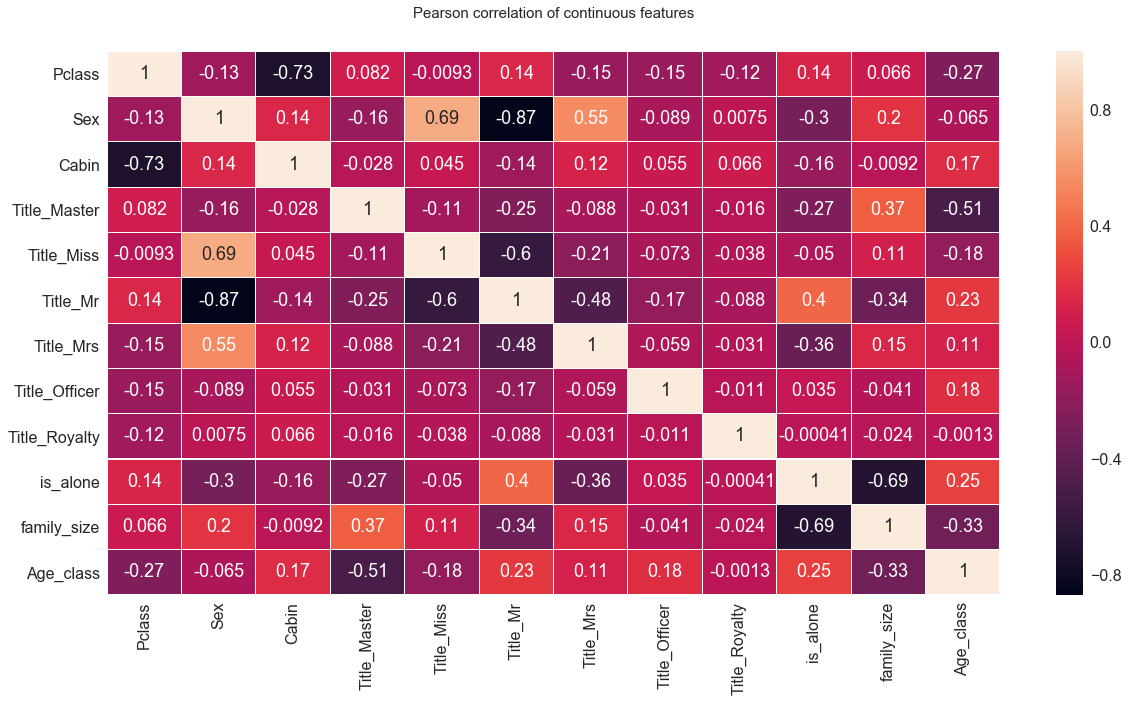

In [409]:
plt.figure(figsize=(20, 10))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(X_train.corr(),linewidths=0.1,vmax=1.0, square=False, cmap=None, linecolor='white', annot=True)
plt.show()


In [282]:
#X_train.head()

## 6.3 Determinando os parâmetros testados

In [77]:
# Cria a lista de parâmetros para calibrar
parameters = {}

#Logistic Regression
parameters['LR'] = {'solver':('newton-cg', 'lbfgs', 'liblinear', 'saga'), 
                    'C':[ 0.01, 0.1, 1.0, 10, 100, 500, 1000, 5000], 
                    'max_iter':[50, 100, 400, 700],
                    'random_state':[420],
                    'n_jobs':[-1]
                   }

#Random forest
parameters['RF'] = {'n_estimators':[ 10, 50, 200, 500], 
                    'max_depth':[5, 7, 10, 15, 25],
                    'min_samples_split':[2, 5, 10, 30, 50],
                    'min_samples_leaf':[5, 10, 20, 30],
                    'random_state':[420]
                    }
 

# Suport Vector Machine            
parameters['SVC'] = {'kernel': ['rbf', 'sigmoid'], 
                     'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
                     'C': [0.1, 1, 10, 100, 500, 1e3, 5e3, 1e4, 5e4, 1e5]
                    }
                    
    
#XGBoost
parameters['XGB'] = {'n_estimators':[10, 50, 100], 
                     'min_child_weight': [1, 5, 10],
                     'gamma': [0, 0.5, 1, 1.5, 2],
                     'subsample': [0.8, 1.0],
                     'colsample_bytree': [0.6, 0.8, 1.0],
                     'max_depth': [3, 4, 5, 7, 10, 13],
                     'random_state':[2017],
                     }


#KNN
parameters['KNN'] = {'n_neighbors':[2],
                     'algorithm':('auto', 'ball_tree', 'kd_tree'),
                     'n_jobs':[-1]
                    }


In [78]:
models = {}

models['LR'] = LogisticRegression()
models['KNN'] = KNeighborsClassifier()
models['RF'] = RandomForestClassifier()
models['SVC'] = SVC(probability=True)
models['XGB'] = XGBClassifier()
#models['Bayesian'] = GaussianNB()


## 6.4 Buscando os melhores parâmetros

In [79]:
#faz o GridSearch para cada clf
from time import time
clf = {}

for name in models.keys():
    
    model = models[name]
    start = time()
    print('o modelo ', name, " está sendo treinado")
    
    grid_obj = GridSearchCV(estimator = model, 
                            param_grid = parameters[name], 
                            scoring = make_scorer(f1_score, pos_label=0),
                            n_jobs = -1,
                            cv = StratifiedShuffleSplit(random_state = 420)
                           )
    
    grid_obj = grid_obj.fit(X_train, y_train)
    clf[name] = grid_obj.best_estimator_
    print(clf[name])
    #print(clf[name].best_params_)
    
    end = time()
    
    print (' ')
    print ("O modelo foi treinado em {:.4f} segundos".format(end - start))
    print (' ')

o modelo  LR  está sendo treinado
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=420, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
 
O modelo foi treinado em 25.2581 segundos
 
o modelo  KNN  está sendo treinado
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')
 
O modelo foi treinado em 6.0729 segundos
 
o modelo  RF  está sendo treinado
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=420,

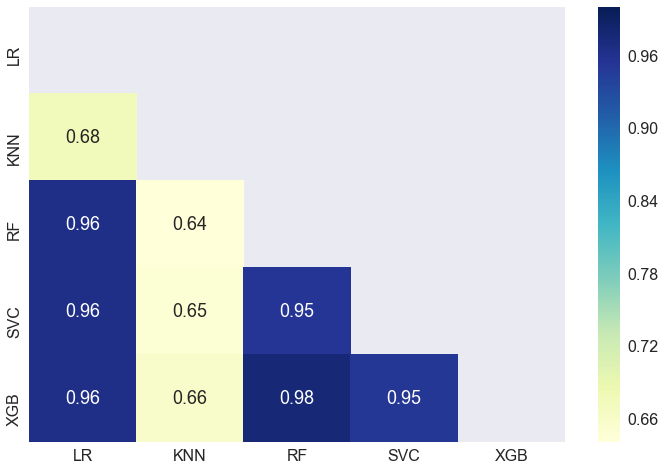

In [80]:
#Plota a matriz de correlação para cada classificador, para ver se eles estão concordadndo ou não.
# Aqui, a discordÂncia é o procurado. Classificadores que concordam muito enviesam o stacking
predictions = get_predictions(clf, X_train, y_train)
models_correlation(predictions)

In [109]:
# Mostra a matriz de predições (Y é a coluna com os valores certos)
predictions = get_predictions(clf, X_train, y_train)
predictions.head()

,Y,LR,KNN,RF,SVC,XGB
0,0,1,0,1,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [82]:
# FAz um Grid Search para o modelo que vai ser o stack do ensemble
grid_obj_stack = GridSearchCV(estimator = LogisticRegression(), 
                            param_grid = parameters['LR'], 
                            scoring = make_scorer(f1_score, pos_label=0),
                            n_jobs = -1,
                            cv = StratifiedShuffleSplit(random_state = 420)
                           )
        

In [110]:
grid_obj_stack = grid_obj_stack.fit(predictions.drop(['Y'], axis = 1), predictions['Y'])
classif = grid_obj_stack.best_estimator_

In [111]:
# Determina os parametros do ensemble
stack = Ensemble(n_splits=3,
        stacker = classif,
        base_models = (clf['LR'], 
                       clf['XGB'], 
                       clf['KNN'],
                       #clf['SVC'], 
                       clf['RF']
                       #clf['Bayesian']
                      ))


In [117]:
# Realiza o método stacking de ensemble, com cross validation
y_pred = stack.fit_predict(X_train, y_train, X_test)

Fit LogisticRegression fold 1
Fit LogisticRegression fold 2
Fit LogisticRegression fold 3
Fit XGBClassifier fold 1
Fit XGBClassifier fold 2
Fit XGBClassifier fold 3
Fit KNeighborsClassifier fold 1
Fit KNeighborsClassifier fold 2
Fit KNeighborsClassifier fold 3
Fit RandomForestClassifier fold 1
Fit RandomForestClassifier fold 2
Fit RandomForestClassifier fold 3
Stacker score: 0.85633


In [118]:
# Como os resultados são obtidos em probabilidades, determina a partir de qual probabilidade aceita-se como sobrevivencia.
y_pred = np.where(y_pred < 0.50 , 0, 1)

In [119]:
#

In [120]:
print("A porcentagem de pessoas sobreviventes prevista é de: %.2f" % ((y_pred == 1).sum()/len(y_pred)*100))
print()
print("Tamanho da array de previsão: ", len(y_pred))



A porcentagem de pessoas sobreviventes prevista é de: 37.56

Tamanho da array de previsão:  418


## 7. Submetendo!!

In [121]:
# cria um dataframe com o id do teste e y_pred
sub = pd.DataFrame()
sub['PassengerId'] = id_test
sub['Survived'] = y_pred


In [122]:
#Cria um nome de documento com as variáveis que ficaram de fora (para melhor controle)
nome_doc = 'SEM ' + ', '.join(str(x) for x in retirar) + '.csv'

In [123]:
#Salva o arquivo no formato .csv
sub.to_csv(nome_doc, index=False)

## 8. Referências

- https://www.kaggle.com/masumrumi/a-statistical-analysis-of-titanic-with-ml-models
- https://github.com/felipeeeantunes/udacity_live
- https://github.com/paulozip/live_coding_udacity_ceaps
- https://github.com/gilmar/udacity-live-coding-ensembles/blob/master/udacity-live-coding-ensembles-stacking.ipynb
- https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html
    